# Demo GPU computation
This demonstrates the use of low-level routines with a GPU.

### Generate fake data

In [1]:
from edge_analyzer import channel_waveform
from scipy import signal
from edge_analyzer.io import simulated_awgn

duration = 4
source.sample_rate = 14e6
source.analysis_bandwidth = 10e6

raw_iq = simulated_awgn(duration, source.sample_rate)

### Analysis bandpass filter

In [2]:
%timeit -n1 -r1

filter_params = dict(
    passband_ripple_dB=0.1,
    stopband_attenuation_dB=70,
    transition_bandwidth_Hz=250e3,
)

sos = channel_waveform.generate_iir_lpf(
    cutoff_Hz=source.analysis_bandwidth / 2, source.sample_rate=source.sample_rate, **filter_params
).astype('float32')

iq_cpu = signal.sosfilt(sos, raw_iq)

In [3]:
import torch

if torch.backends.mps.is_available():
    # device = torch.device("mps")
    torch.set_default_device('mps')
else:
    device = None
    print('MPS device not found.')

iq_gpu = torch.asarray(iq_cpu)

### Channel power time-series

In [4]:
pvt = channel_waveform.power_time_series(
    iq_gpu,
    source.sample_rate=source.sample_rate,
    source.analysis_bandwidth=source.analysis_bandwidth,
    detector_period=10e-3,
    detectors=('rms', 'peak'),
)

In [5]:
%%timeit -n1 -r1

channel_waveform.power_time_series(
    iq_gpu,
    source.sample_rate=source.sample_rate,
    source.analysis_bandwidth=source.analysis_bandwidth,
    detector_period=10e-3,
    detectors=('rms', 'peak'),
)

10.5 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


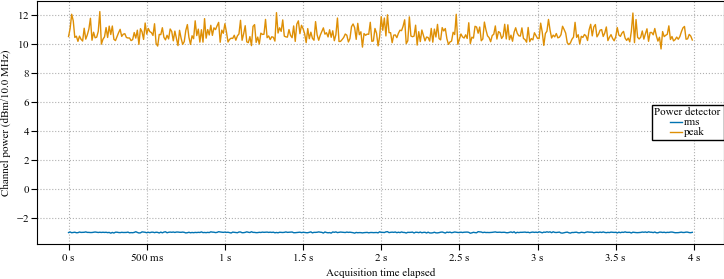

In [6]:
from iqwaveform import powtodB
from matplotlib import pyplot as plt
from edge_analyzer import figures

plt.style.use('iqwaveform.ieee_double_column')

fig, ax = plt.subplots()

pvt.plot.line(x='time_elapsed', ax=ax)

figures.label_axis(ax.xaxis, pvt, 'time_elapsed')
figures.label_axis(ax.yaxis, pvt, tick_units=False)
figures.label_legend(ax, pvt, 'power_detector')

### Cyclic channel power

In [7]:
cyclic_power = channel_waveform.cyclic_channel_power(
    iq_gpu,
    source.sample_rate,
    source.analysis_bandwidth=source.analysis_bandwidth,
    cyclic_period=10e-3,
    detector_period=1e-3 / 14 / 4,
    detectors=('rms', 'peak'),
    cyclic_statistics=('min', 'mean', 'max'),
)

In [8]:
%%timeit -n1 -r1
print('GPU execution')
cyclic_power = channel_waveform.cyclic_channel_power(
    iq_gpu,
    source.sample_rate,
    source.analysis_bandwidth=source.analysis_bandwidth,
    cyclic_period=10e-3,
    detector_period=1e-3 / 14 / 4,
    detectors=pvt.power_detector.values,
    cyclic_statistics=('min', 'mean', 'max'),
)

GPU execution
14.9 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [9]:
%%timeit -n1 -r1
print('CPU execution')
cyclic_power = channel_waveform.cyclic_channel_power(
    iq_cpu,
    source.sample_rate,
    source.analysis_bandwidth=source.analysis_bandwidth,
    cyclic_period=10e-3,
    detector_period=1e-3 / 14 / 4,
    detectors=pvt.power_detector.values,
    cyclic_statistics=('min', 'mean', 'max'),
)

CPU execution
398 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


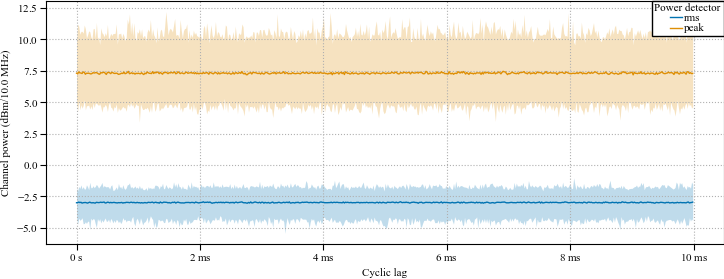

In [10]:
fig, ax = plt.subplots()

time = cyclic_power.cyclic_lag

for i, detector in enumerate(cyclic_power.power_detector.values):
    a = cyclic_power.sel(power_detector=detector)

    ax.plot(time, powtodB(a.sel(cyclic_statistic='mean')), color=f'C{i}')

for i, detector in enumerate(cyclic_power.power_detector.values):
    a = cyclic_power.sel(power_detector=detector)

    ax.fill_between(
        time,
        powtodB(a.sel(cyclic_statistic='min')),
        powtodB(a.sel(cyclic_statistic='max')),
        color=f'C{i}',
        alpha=0.25,
        lw=0,
        rasterized=True,
    )

figures.label_axis(ax.xaxis, cyclic_power, 'cyclic_lag')
figures.label_axis(ax.yaxis, cyclic_power, tick_units=False)
figures.label_legend(ax, cyclic_power, 'power_detector')

### Persistence Spectrum

In [11]:
frequency_resolution = 16e3
spectrum_quantiles = [0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 1]

spectrum = channel_waveform.persistence_spectrum(
    iq_gpu,
    source.sample_rate=source.sample_rate,
    window='flattop',
    resolution=frequency_resolution,
    quantiles=spectrum_quantiles,
)
spectrum

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'> <module 'array_api_compat.torch' from '/opt/homebrew/Caskroom/mambaforge/base/envs/spectrum-sensor-edge-analysis/lib/python3.9/site-packages/array_api_compat/torch/__init__.py'>
<class 'torch.Tensor'>


<xarray.DataArray 'persistence_spectrum' (baseband_frequency: 875,
                                          persistence_statistic: 9)>
array([[-114.619026,  -92.29141 , -103.0753  , ..., -114.981834,
               -inf,        -inf],
       [ -45.307083,  -33.277515,  -34.77364 , ...,  -28.275581,
         -41.105164,  -29.36522 ],
       [-103.584785,  -94.39177 , -101.61956 , ..., -116.14716 ,
               -inf,        -inf],
       ...,
       [ -35.297   ,  -40.945107,  -25.992035, ...,  -57.757507,
               -inf,        -inf],
       [-112.60292 , -116.76846 , -111.81598 , ...,  -96.3788  ,
         -94.32417 , -103.17522 ],
       [ -39.33616 ,  -34.99652 ,  -25.558758, ...,  -60.170918,
               -inf,        -inf]], dtype=float32)
Coordinates:
  * baseband_frequency     (baseband_frequency) float64 -6.992e+06 ... 6.992e+06
  * persistence_statistic  (persistence_statistic) <U5 '0.1' '0.25' ... '1'
Attributes:
    label:               Power spectral density
    units:               dBm/60.324 kHz
    window:              flattop
    resolution_Hz:       16000.0
    fractional_overlap:  0
    noise_bandwidth_Hz:  60323.943159094866
    fft_size:            875

In [12]:
%%timeit -n1 -r1
spectrum = channel_waveform.persistence_spectrum(
    iq_gpu,
    source.sample_rate=source.sample_rate,
    window='flattop',
    resolution=frequency_resolution,
    quantiles=spectrum_quantiles,
)

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'> <module 'array_api_compat.torch' from '/opt/homebrew/Caskroom/mambaforge/base/envs/spectrum-sensor-edge-analysis/lib/python3.9/site-packages/array_api_compat/torch/__init__.py'>
<class 'torch.Tensor'>
96.7 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


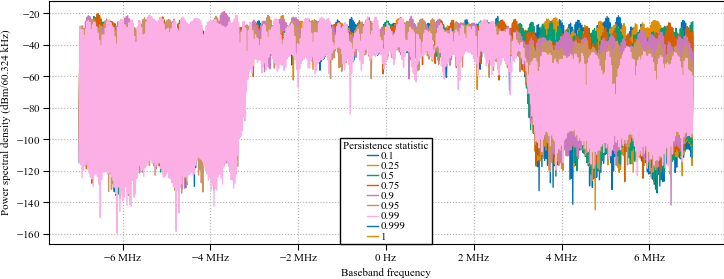

In [13]:
fig, ax = plt.subplots()

spectrum.plot.line(x='baseband_frequency', ax=ax)
figures.label_axis(ax.xaxis, spectrum, 'baseband_frequency')
figures.label_axis(ax.yaxis, spectrum, tick_units=False)
figures.label_legend(ax, spectrum, 'persistence_statistic')

### Amplitude Probability Distribution

In [14]:
apd_bins = dict(power_low=-40.0, power_high=15.0, power_count=55 * 4 + 1)

apd = channel_waveform.amplitude_probability_distribution(
    iq_gpu, source.analysis_bandwidth=source.analysis_bandwidth, **apd_bins
)

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Discarded (victim of GPU error/recovery) (00000005:kIOGPUCommandBufferCallbackErrorInnocentVictim)
	<AGXG14XFamilyCommandBuffer: 0x33dc6b4d0>
    label = <none> 
    device = <AGXG14CDevice: 0x179dec800>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x107f3dc00>
        label = <none> 
        device = <AGXG14CDevice: 0x179dec800>
            name = Apple M2 Max 
    retainedReferences = 1


In [15]:
# %%timeit -n1 -r1
# apd = channel_waveform.amplitude_probability_distribution(
#     iq_gpu, source.analysis_bandwidth=source.analysis_bandwidth, **apd_bins
# )